# Introduction

This notebook applies the methods of parametrized classification to the Pythia electron-positron scattering dataset (https://zenodo.org/record/3518708). The data for each jet has 7 entries and takes the form $(p_T,\eta,\phi,\text{pID},\theta_1,\theta_2,\theta_3)$. These quantities are defined as follows:
- $p_T$: tranverse momentum of the particle
- $\eta$: pseudorapidity (i.e. the angle of the particle relative to the beam axis)
- $\phi$: azimuthal angle (i.e. the angle in the plane transverse to the beam)
- PID: Particle IDentification (for numbering scheme information see https://pdg.lbl.gov/2007/reviews/montecarlorpp.pdf)
- $\theta_1$: 𝚃𝚒𝚖𝚎𝚂𝚑𝚘𝚠𝚎𝚛:𝚊𝚕𝚙𝚑𝚊𝚂𝚟𝚊𝚕𝚞𝚎 $\in [0.10, 0.18]$ ("effective" strong coupling constant $\alpha_S$)
- $\theta_2$: 𝚂𝚝𝚛𝚒𝚗𝚐𝚉:𝚊𝙻𝚞𝚗𝚍 $\in [0.50, 0.90]$ (Hadronization, determines how partons become hadrons, String model, $Z$)
- $\theta_3$: 𝚂𝚝𝚛𝚒𝚗𝚐𝙵𝚕𝚊𝚟:𝚙𝚛𝚘𝚋𝚂𝚝𝚘𝚄𝙳 $\in [0.10, 0.30]$ (modeling parameters determining Strange behavior)

These $\theta_i$ values are Pythia parameters and were sampled uniformly according to the bounds shown above.

## Imports

In [1]:
import os
import sys
os.environ['KMP_DUPLICATE_LIB_OK']='True'
sys.path.append('/Users/matangrinberg/Library/CloudStorage/GoogleDrive-matan.grinberg@gmail.com/My Drive/(21-24) University of California, Berkeley/ML HEP/parametrized-classifiers/data')

In [2]:
# standard library imports
from __future__ import absolute_import, division, print_function

# standard numerical library imports
import numpy as np
import scipy as sp
import tensorflow as tf
import keras

# energyflow imports
import energyflow as ef
from energyflow.archs import PFN
from energyflow.utils import data_split, remap_pids, to_categorical

import matplotlib.pyplot as plt

In [13]:
# Global plot settings
# from matplotlib import rc
# import matplotlib.font_manager
# rc('font', family='serif')
# rc('text', usetex=True)
# rc('font', size=22) 
# rc('xtick', labelsize=15) 
# rc('ytick', labelsize=15) 
# rc('legend', fontsize=15)

# Load Data

## Utilities

In [3]:
# normalize pT and center (y, phi)
def normalize(x):
    mask = x[:,0] > 0
    yphi_avg = np.average(x[mask,1:3], weights=x[mask,0], axis=0)
    x[mask,1:3] -= yphi_avg
    x[mask,0] /= x[:,0].sum()
    
def preprocess_data(X):
    for x in X:
        normalize(x)
    
    # Remap PIDs to unique values in range [0,1], error_on_unknown flag for PIDs not in dictionary
    remap_pids(X, pid_i=3, error_on_unknown=False)
    return X

## Process data

In [4]:
# Path to downloaded data from Zenodo
data_dir = '/Users/matangrinberg/Library/CloudStorage/GoogleDrive-matan.grinberg@gmail.com/My Drive/(21-24) University of California, Berkeley/ML HEP/parametrized-classifiers/data/'

In [5]:
dataset = np.load(data_dir + '1D_alphaS_train.npz')

In [6]:
X = preprocess_data(dataset['X'])
Y = to_categorical(dataset['Y'], num_classes=2)

In [11]:
X.shape

(1800000, 51, 7)

In [12]:
X_train, X_val, Y_train, Y_val = data_split(X, Y, test=0.1)

In [13]:
print(X_train.shape)
print(Y_train.shape)
print(X_val.shape)
print(Y_val.shape)

(1620000, 51, 7)
(1620000, 2)
(180000, 51, 7)
(180000, 2)


In [17]:
print(X_train[0, 0])

[ 0.00350312  0.79472989 -0.17868867  0.          0.175713    0.68000001
  0.21699999]


# Building/Training Interpolated Model

In [14]:
# network architecture parameters
Phi_sizes = (100,100,128)
F_sizes = (100,100,100)

model_interpolate = PFN(input_dim=7, Phi_sizes=Phi_sizes, F_sizes=F_sizes, summary=False)

In [15]:
save_label = 'DCTR_ee_dijets_1D_alphaS'
checkpoint = keras.callbacks.ModelCheckpoint('./saved_models/' + save_label + '.h5', monitor='val_loss', verbose=2, save_best_only=True, mode='min')
CSVLogger = keras.callbacks.CSVLogger('./logs/' + save_label + '_loss.csv', append=False)
EarlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, restore_best_weights=True)
callbacks = [checkpoint, CSVLogger, EarlyStopping]

# epochs = 10
epochs = 100
batch_size = 1000

In [18]:
history = model_interpolate.fit(X_train, Y_train,
                    epochs = epochs,
                    batch_size = batch_size,
                    validation_data = (X_val, Y_val),
                    verbose = 1, 
                    callbacks = callbacks)

Epoch 1/100
1620/1620 [==============================] - ETA: 0s - loss: 0.6879 - acc: 0.5373
Epoch 1: val_loss improved from inf to 0.68478, saving model to ./saved_models/DCTR_ee_dijets_1D_alphaS.h5
1620/1620 [==============================] - 89s 55ms/step - loss: 0.6879 - acc: 0.5373 - val_loss: 0.6848 - val_acc: 0.5472
Epoch 2/100
1620/1620 [==============================] - ETA: 0s - loss: 0.6820 - acc: 0.5546
Epoch 2: val_loss improved from 0.68478 to 0.68077, saving model to ./saved_models/DCTR_ee_dijets_1D_alphaS.h5
1620/1620 [==============================] - 84s 52ms/step - loss: 0.6820 - acc: 0.5546 - val_loss: 0.6808 - val_acc: 0.5575
Epoch 3/100
1620/1620 [==============================] - ETA: 0s - loss: 0.6808 - acc: 0.5569
Epoch 3: val_loss did not improve from 0.68077
1620/1620 [==============================] - 82s 51ms/step - loss: 0.6808 - acc: 0.5569 - val_loss: 0.6816 - val_acc: 0.5539
Epoch 4/100
1619/1620 [============================>.] - ETA: 0s - loss: 0.680

## Plot History

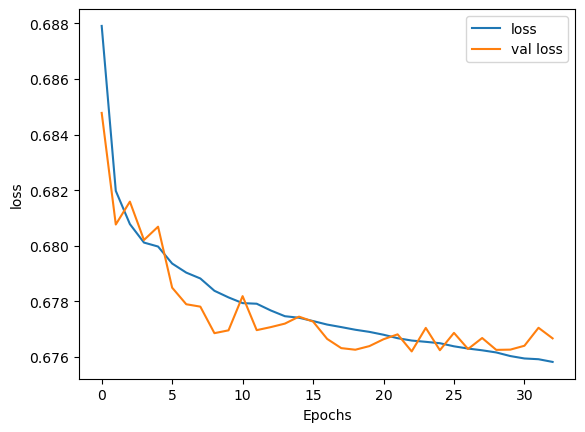

In [19]:
plt.plot(history.history['loss'],     label = 'loss')
plt.plot(history.history['val_loss'], label = 'val loss')
plt.legend(loc=0)
plt.ylabel('loss')
plt.xlabel('Epochs')
plt.show()

# Load Interpolated Model

In [16]:
# load model from saved file
model_interpolate.model.load_weights('./saved_models/DCTR_ee_dijets_1D_alphaS.h5')

## Load Datasets

In [17]:
test_dataset_0 = np.load(data_dir+'test1D_default.npz')
test_dataset_1 = np.load(data_dir+'test1D_alphaS.npz')

## Get predictions

In [ ]:
# Load test datasets
X0_test = preprocess_data(test_dataset_0['jet'])
X1_test = preprocess_data(test_dataset_1['jet'])

In [20]:
# Get predicted probabilities
preds_0 = dctr.predict(X0_test, batch_size=1000)
preds_1 = dctr.predict(X1_test, batch_size=1000)

## Get weights

In [21]:
weights_0 = preds_0[:,0]/preds_0[:,1]
weights_1 = preds_1[:,0]/preds_1[:,1]

In [25]:
# Define default plot styles
plot_style_0 = {'histtype':'step', 'color':'black', 'linewidth':2, 'linestyle':'--', 'density':True}
plot_style_1 = {'alpha':0.5, 'density':True}

# Fitting

## Parameter-Finder Model

In [28]:
class AddParams2Input(keras.layers.Layer):
    """ Custom layer for tuning parameters: 
    Arguments:
    - n_params : (int) - the number of n_params that are in X_dim
    - default_params : (list of floats) - initial values for each of the parameters
    - trainable_params : (list of booleans) - True for parameters that you want to fit, false for parameters that should be fixed at default value

    Usage: 
    Let X_dim be the input dimension of each particle to a PFN model, and n_params be the number of MC parameters. 
    Defines a Layer that takes in an array of dimension 
    (batch_size, padded_multiplicity, X_dim - n_params)
    This layer appends each particle by the default_params and makes then trainable or non-trainable based on trainable_params
    """
    
    def __init__(self, n_params, default_params, trainable_params):
        super(AddParams2Input, self).__init__()
        # Definitions
        self.n_params = n_params
        self.params = default_params
        self.trainable_params = trainable_params
        self.loss_fn = tf.keras.losses.BinaryCrossentropy()
        self.models = []

    
    def build(self, input_shape):
        # Convert input parameters to weights and make then trainable or non-trainable
        for i in range(self.n_params):
            # Create weight in layer for each parameter, trainable depending on trainable_params (Binary)
            self.params[i] = self.add_weight(name='param_{}'.format(i), shape=(1, 1), initializer=keras.initializers.Constant(self.params[i]), trainable=self.trainable_params[i])
            
        self.params = keras.backend.concatenate(self.params, axis = -1)
        super(AddParams2Input, self).build(input_shape)
        
    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1] + self.n_params)         

In [24]:
def model_parameter_finder(model_interpolate, X_dim, n_params, default_params, trainable_params):
    """ 
    Get a model that trains on the input parameters
    
    Arguments:
    - model_interpolate : a PFN model that has been trained to continuously interpolate over the input parameter dimensions
    - X_dim : (int) - the dimension of the input expected by DCTR_model
    - n_params : (int) - the number of n_params that are in X_dim
    - default_params : (list of floats) - default values for each of the parameters
    - trainable_params : (list of booleans) - True for parameters that you want to fit, false for parameters that should be fixed at default value

    Returns:
    - model_parameter_finder: a compiled model that gradient descends only on the trainable parameters
    """
    
    # Do sanity checks on inputs
    assert X_dim >=n_params, "X_dim must be larger than n_params. X_dim includes the dimensionality of the 4-vector + number of parameters"
    assert n_params == len(default_params), "Dimension mismatch between n_params and number of default parameters given. len(default_params) must equal n_params"
    assert n_params == len(trainable_params), "Dimension mismatch between n_params and trainable_params. len(trainable_params) must equal n_params."
    assert np.any(trainable_params), "All parameters are set to non-trainable."
    
    # Define input to DCTR_fit_model
    non_param_input = keras.layers.Input((None, X_dim - n_params))

    # Construct layer that adds trainable and non-trainable parameters to the input
    add_params_layer = AddParams2Input(n_params, default_params, trainable_params)
    time_dist     = keras.layers.TimeDistributed(add_params_layer, name='tdist')(non_param_input)     

    # Set all weights in interpolation_model to non-trainable
    for layer in model_interpolate.layers:
        layer.trainable = False
        
    # get the graph and the weights from the interpolation model
    output = model_interpolate.model(inputs = time_dist)

    # Define full model
    model_parameter_finder = fitmodel = keras.models.Model(inputs = non_param_input, outputs = output)
    optimizer = keras.optimizers.Adam(lr=1e-4)
    # loss = keras.losses.BinaryCrossentropy()
    
    # Compile with loss function
    model_parameter_finder.compile(optimizer=optimizer, loss='categorical_crossentropy')
    
    return model_parameter_finder


def set_params(model, params):
    alphaS, aLund, StoUD = params
    weights = [np.array([[alphaS]], dtype=np.float32), np.array([[aLund]], dtype=np.float32), np.array([[StoUD]], dtype=np.float32)]
    model.layers[1].set_weights(weights)

In [32]:
model_interpolate_pf = model_parameter_finder(model_interpolate, X_dim =7, n_params = 3, 
                       default_params   = [0.1365, 0.68, 0.217], # default params for [alpha_s, aLund, StoUD]
                       trainable_params = [True, False, False]) # Only train alpha_s

model_interpolate_pf.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, None, 4)]         0         
                                                                 
 tdist (TimeDistributed)     (None, None, 7)           3         
                                                                 
 model_1 (Functional)        (None, 2)                 57130     
                                                                 
Total params: 57,133
Trainable params: 1
Non-trainable params: 57,132
_________________________________________________________________


In [34]:
model_interpolate_pf.layers[1].get_weights()

[array([[0.1365]], dtype=float32),
 array([[0.68]], dtype=float32),
 array([[0.217]], dtype=float32)]

## Load Data

In [35]:
default_dataset = np.load(data_dir + 'test1D_default.npz')
unknown_dataset = np.load(data_dir + 'test1D_alphaS.npz')

In [36]:
X_default = preprocess_data(default_dataset['jet'][:,:,:4])
X_unknown = preprocess_data(unknown_dataset['jet'][:,:,:4])

Y_default = np.zeros_like(X_unknown[:,0,0])
Y_unknown = np.ones_like(X_unknown[:,0,0])

In [37]:
X_fit = np.concatenate((X_default, X_unknown), axis = 0)

Y_fit = np.concatenate((Y_default, Y_unknown), axis = 0)
Y_fit = to_categorical(Y_fit, num_classes=2)

In [38]:
X_fit, _, Y_fit, _ = data_split(X_fit, Y_fit, test=0, shuffle=True)

## Evaluate Loss as a function of MC parameter

In [48]:
alpha_loss = np.array([(a, get_loss(X_fit, Y_fit, dctr_fit_model, [a, 0.68, 0.217])) for a in np.linspace(0.1,0.18, 31)])

ValueError: in user code:

    File "/opt/anaconda3/envs/pc/lib/python3.10/site-packages/keras/engine/training.py", line 1557, in test_function  *
        return step_function(self, iterator)
    File "/opt/anaconda3/envs/pc/lib/python3.10/site-packages/keras/engine/training.py", line 1546, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/anaconda3/envs/pc/lib/python3.10/site-packages/keras/engine/training.py", line 1535, in run_step  **
        outputs = model.test_step(data)
    File "/opt/anaconda3/envs/pc/lib/python3.10/site-packages/keras/engine/training.py", line 1499, in test_step
        y_pred = self(x, training=False)
    File "/opt/anaconda3/envs/pc/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/var/folders/m2/185h3bxj77z7vy89y472mwq40000gn/T/__autograph_generated_filemjpprwrz.py", line 11, in tf__call
        concat_input_and_params = ag__.converted_call(ag__.ld(keras).backend.tf.where, (ag__.converted_call(ag__.ld(keras).backend.abs, (ag__.ld(input)[..., 0],), None, fscope) > 0, ag__.ld(self).MC_params * ag__.converted_call(ag__.ld(keras).backend.ones_like, (ag__.ld(input)[..., 0:ag__.ld(self).n_MC_params],), None, fscope), ag__.converted_call(ag__.ld(keras).backend.zeros_like, (ag__.ld(input)[..., 0:ag__.ld(self).n_MC_params],), None, fscope)), None, fscope)

    ValueError: Exception encountered when calling layer "add_params2_input_1" (type AddParams2Input).
    
    in user code:
    
        File "/var/folders/m2/185h3bxj77z7vy89y472mwq40000gn/T/ipykernel_48739/3443221890.py", line 36, in call  *
            concat_input_and_params = keras.backend.tf.where(keras.backend.abs(input[...,0])>0,
    
        ValueError: Dimensions must be equal, but are 1000 and 3 for '{{node model_2/tdist/add_params2_input_1/SelectV2}} = SelectV2[T=DT_FLOAT](model_2/tdist/add_params2_input_1/Greater, model_2/tdist/add_params2_input_1/mul, model_2/tdist/add_params2_input_1/zeros_like)' with input shapes: [1000], [1000,3], [1000,3].
    
    
    Call arguments received by layer "add_params2_input_1" (type AddParams2Input):
      • input=tf.Tensor(shape=(1000, 4), dtype=float32)


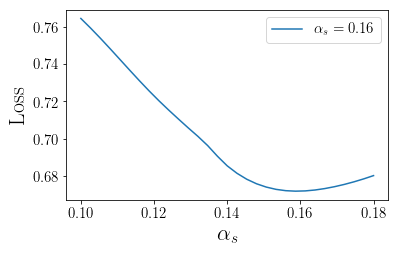

In [43]:
plt.plot(*alpha_loss.T, label = label_1)
plt.ylabel('Loss')
plt.xlabel(r'$\alpha_s$')
plt.legend()
plt.tight_layout()
plt.show()

In [44]:
def get_min_loss(losses, x0):
    f = sp.interpolate.interp1d(losses[:,0], losses[:,1], fill_value="extrapolate")
    return sp.optimize.minimize(f, x0=x0)['x']

get_min_loss(alpha_loss, x0=0.1365)

array([0.15866666])

## Tune with Gradient Descent

In [45]:
print_weights = keras.callbacks.LambdaCallback(on_epoch_end=lambda batch, logs: print("alpha_s fit = ", 
                                               dctr_fit_model.get_weights()[0][0][0]))
fit_vals = [0.1365]
append_weights = keras.callbacks.LambdaCallback(on_epoch_end=lambda batch, logs: 
                                               fit_vals.append(dctr_fit_model.get_weights()[0][0][0]))

callbacks = [print_weights, append_weights]

In [46]:
dctr_fit_model.fit(X_fit, Y_fit,
                   epochs=10, 
                   batch_size=10000,
                   callbacks = callbacks)

Epoch 1/10
1800000/1800000 [==============================] - 9s 5us/step - loss: 0.6757
alpha_s fit =  0.16495736
Epoch 2/10
1800000/1800000 [==============================] - 9s 5us/step - loss: 0.6721
alpha_s fit =  0.15957834
Epoch 3/10
1800000/1800000 [==============================] - 9s 5us/step - loss: 0.6719
alpha_s fit =  0.15915796
Epoch 4/10
1800000/1800000 [==============================] - 9s 5us/step - loss: 0.6719
alpha_s fit =  0.15901665
Epoch 5/10
1800000/1800000 [==============================] - 9s 5us/step - loss: 0.6719
alpha_s fit =  0.15895784
Epoch 6/10
1800000/1800000 [==============================] - 9s 5us/step - loss: 0.6719
alpha_s fit =  0.15907158
Epoch 7/10
1800000/1800000 [==============================] - 9s 5us/step - loss: 0.6719
alpha_s fit =  0.15906122
Epoch 8/10
1800000/1800000 [==============================] - 9s 5us/step - loss: 0.6719
alpha_s fit =  0.15884054
Epoch 9/10
1800000/1800000 [==============================] - 9s 5us/step - loss

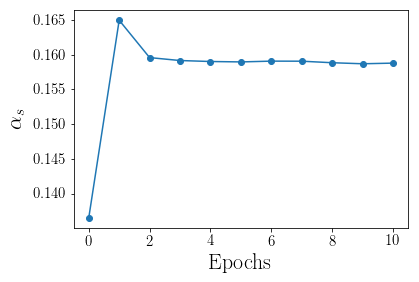

In [47]:
plt.plot(fit_vals, marker='o')
plt.xlabel("Epochs")
plt.ylabel(r'$\alpha_s$')
plt.show()